In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import msgpack
from collections import OrderedDict

In [138]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

In [139]:
import torch_geometric

In [140]:
from torch_geometric.nn import GCNConv, global_add_pool, global_mean_pool, Set2Set, GATv2Conv, GlobalAttention
from torch_geometric.loader import DataLoader

In [141]:
from dataset import ExcitedDataset, GeometricTransform

In [142]:
method = "gap"

In [135]:
for method in ['log', 'normalize', 'gap', 'loggap']:
    os.system("rm -rf processed")
    ds = ExcitedDataset(".", pre_transform=GeometricTransform(method))
    test_dataset = ds[int(len(ds)*0.9):]
    test_batch = next(iter(test_dl))
    test_dl = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    torch.save([test_batch.y, test_batch.ground_state], f"test_batch_{method}.pt")

Processing...
Processing data...: 100%|████████████████████████████████████| 5927/5927 [00:08<00:00, 735.64it/s]
Done!
Processing...
Processing data...: 100%|████████████████████████████████████| 5927/5927 [00:08<00:00, 718.37it/s]
Done!
Processing...
Processing data...: 100%|████████████████████████████████████| 5927/5927 [00:08<00:00, 725.38it/s]
Done!
Processing...
Processing data...: 100%|████████████████████████████████████| 5927/5927 [00:08<00:00, 693.56it/s]
Done!


In [143]:
ds = ExcitedDataset(".", pre_transform=GeometricTransform(method))

In [144]:
train_dataset = ds[:int(len(ds)*0.9)]
test_dataset = ds[int(len(ds)*0.9):]

In [145]:
dl = DataLoader(ds, batch_size=32, shuffle=True)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
train_dl_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
dl_all = DataLoader(ds, batch_size=len(ds), shuffle=True)
test_batch = next(iter(test_dl))

In [146]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(6, 24)
        self.conv2 = GCNConv(24, 10)
        
        self.pool = global_add_pool
        self.fc1 = nn.Linear(10, 1)
        
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index, edge_weight)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        
        x = self.pool(x, data.batch)
        x = self.fc1(x)
        #x = torch.tanh(x)
        # x = self.fc2(x)
        
        return x

In [147]:
class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATv2Conv(6, 24)
        self.conv2 = GATv2Conv(24, 24)
        
        self.pool = global_add_pool
        # self.set2set = Set2Set(16, processing_steps=10)
        # self.fc2 = nn.Linear(32, 16)
        self.fc1 = nn.Linear(24, 1)
        
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index, edge_weight)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        
        x = self.pool(x, data.batch)
        x = self.fc1(x)
        
        return x

In [ ]:

train_batch_eval = next(iter(train_dl_all))

device = torch.device("cpu")
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5.e-4)
model.train()
losses = []
Nepochs=200
for epoch in range(Nepochs):
    model.train()
    if epoch % (Nepochs//10) == 0 and epoch != 0:
        print(f"Epoch {epoch} | Loss: {loss} | Test Loss: {test_loss.detach().numpy()}")
    for batch in train_dl:
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y, reduction="mean")
        loss.backward()
        optimizer.step()
    
    test_loss = F.mse_loss(model(test_batch), test_batch.y, reduction="mean")
    losses.append(test_loss.detach().numpy())

Epoch 20 | Loss: 0.49617298334620297 | Test Loss: 2.1909708048596395
Epoch 40 | Loss: 0.8976462941353294 | Test Loss: 1.0760201511240455
Epoch 60 | Loss: 0.44406351212279843 | Test Loss: 1.468992190134967
Epoch 80 | Loss: 1.0594919433810783 | Test Loss: 1.037589590149305


In [ ]:
# data = []
# def print_value(name):
#     def hook(model, input, output):
#         data.append(output)
#     return hook
# conv1hook = model.conv1.register_forward_hook(print_value("conv1"))
# model.eval()
# train_batch = next(iter(train_dl))
# model(train_batch);

In [ ]:
x1 = test_batch.y.squeeze().detach().numpy()
x2 = model(test_batch).squeeze().detach().numpy()

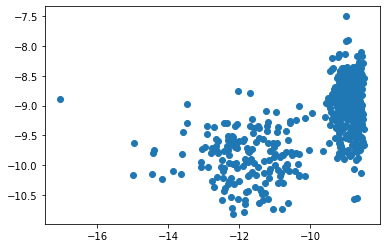

In [150]:
plt.scatter(x1, x2)

In [152]:
import pickle
all_data[(method, "GCN")] = [x1, x2, losses]
with open("all_data.pkl", "wb+") as f:
    pickle.dump(all_data, f)


In [153]:
all_data.keys()

dict_keys([('loggap', 'GCN'), ('loggap', 'GAT'), ('gap', 'GCN'), ('gap', 'GAT'), ('normalize', 'GCN'), ('normalize', 'GAT'), ('log', 'GAT'), ('log', 'GCN')])